# Predictive Modeling for Proactive Packaging Quality Control

This notebook presents the complete modeling workflow for developing a predictive system that identifies defective packaging units before they reach the customer or distribution centers. Building on prior phases of data discovery and feature engineering, the objective of this phase is to translate FashionWorld's business goals into a robust, interpretable, and operationally scalable machine learning solution.

The notebook begins by framing the business problem as a supervised binary classification task, distinguishing between "Good" and "Bad" packaging events. It proceeds to detail the preprocessing steps applied to prepare the data, including categorical encoding, domain-informed feature engineering, and feature selection based on correlation analysis and operational relevance.

Subsequently, five classification algorithms are benchmarked—Logistic Regression, CatBoost, LightGBM, XGBoost, and Random Forest—under a unified cross-validation framework. After evaluating performance with a focus on the minority class (defective packaging), XGBoost is selected as the final model based on its superior recall and balanced performance. A custom threshold optimization strategy is then applied to align the model’s behavior with the company’s risk tolerance, emphasizing early detection of packaging failures.

The final section of the notebook applies interpretability techniques such as SHAP analysis and raw feature importance evaluation to ensure transparency and business alignment. These insights enable quality assurance teams to take targeted corrective actions and support FashionWorld’s transition from reactive to proactive packaging quality control.

---

## Table of Contents

1. [Preprocessing and Feature Engineering](##preprocessing-and-feature-engineering)  
2. [Model Training and Baseline Evaluation](#model-training-and-baseline-evaluation)  
   - [Random Forest](#random-forest)
   - [XGBoost](#xgboost)
   - [LightGBM](#lightgbm)  
   - [CatBoost](#catboost)
   - [Logistic Regression](#logistic-regression) 

3. [Hyperparameter Tuning and Performance Summary](#hyperparameter-tuning-and-performance-summary)  
4. [Final Model Selection and Threshold Optimization](#final-model-selection-and-threshold-optimization)  
5. [Model Interpretability with SHAP](#model-interpretability-with-shap)  


In [58]:
# Core Python Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    make_scorer
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer



## Preprocessing and Feature Engineering

Load Cleaned Datasets:
We load four cleaned datasets: density reports, product attributes, supplier scorecards, and historical incidents.

In [2]:
density_df = pd.read_csv('data/processed/density_reports.csv')
product_df = pd.read_csv('data/processed/product_attributes.csv')
supplier_df = pd.read_csv('data/processed/supplier_scorecard.csv')
incidents_df = pd.read_csv('data/processed/historical_incidents.csv')

Merge Product Attributes into Density Reports

In this step, we enrich the `density_reports` dataset by merging it with product-level information from the `product_attributes` dataset.

- We **drop duplicate or overlapping columns** from the product dataset (`GarmentType`, `Material`, `Weight`, `ProductName`) to avoid conflicts, since these may already exist or differ in the density data.
- The merge is performed using the common key **`ProductReference`**.
- A **left join** ensures all rows from the density dataset are preserved.
- We also validate that each product has only one attribute record (`many_to_one` relationship).

This step brings in important product context such as `Size` and `Collection`, which may help explain variations in packaging quality.


In [3]:
# Drop duplicate columns before merge 
product_df = product_df.drop(columns=['GarmentType', 'Material', 'Weight','ProductName'], errors='ignore')

# Merge on 'ProductReference'
merged_df = pd.merge(
    density_df,
    product_df,
    on='ProductReference',
    how='left',  # Keep all density_reports rows
    validate='many_to_one'  # many density reports per product
)

# Quick check
print(merged_df.shape)
print(merged_df[['ProductReference', 'Size', 'Collection']].head())


(478846, 13)
  ProductReference Size Collection
0         PRD07271    S     Winter
1         PRD00861    M     Winter
2         PRD05391    S     Winter
3         PRD05192   XL     Winter
4         PRD05735    M     Autumn


Checking for missing values in merged DataFrame

In [4]:
merged_df.isnull().sum()

ReportID                  0
ProductReference          0
DateOfReport              0
SupplierName              0
GarmentType               0
Material                  0
Weight                    0
ProposedUnitsPerCarton    0
ProposedFoldingMethod     0
ProposedLayout            0
PackagingQuality          0
Size                      0
Collection                0
dtype: int64

Merge Supplier Scorecard by Month and Supplier

To incorporate supplier performance metrics, we merge the `supplier_scorecard` dataset into the main DataFrame using both `SupplierName` and the report month.

- First, we convert `DateOfReport` and `Month` columns to a common `'YYYY-MM'` format to enable consistent monthly matching.
- The merge is performed on both `SupplierName` and the derived `ReportMonth`, using a left join to preserve all density records.
- This step brings in monthly KPIs such as packaging error rates, on-time delivery, and incident counts per supplier.


In [5]:
# Prepare month info for supplier join
# Ensure datetime for DateOfReport
merged_df['DateOfReport'] = pd.to_datetime(merged_df['DateOfReport'], errors='coerce')
merged_df['ReportMonth'] = merged_df['DateOfReport'].dt.to_period('M').astype(str)

# Parse supplier month column and format to 'YYYY-MM'
supplier_df['Month'] = pd.to_datetime(supplier_df['Month'], errors='coerce')
supplier_df['Month'] = supplier_df['Month'].dt.to_period('M').astype(str)

# Merge with supplier_df 
merged_df = pd.merge(
    merged_df,
    supplier_df,
    left_on=['SupplierName', 'ReportMonth'],
    right_on=['SupplierName', 'Month'],
    how='left',
    validate='many_to_one'
)

# Drop duplicate Month column
merged_df.drop(columns=['Month'], inplace=True)

print(merged_df.shape)
print(merged_df.head())


(478846, 21)
     ReportID ProductReference DateOfReport SupplierName GarmentType  \
0  RPT0000001         PRD07271   2024-03-04    SupplierA       Pants   
1  RPT0000002         PRD00861   2024-05-27    SupplierC     T-Shirt   
2  RPT0000003         PRD05391   2023-11-18    SupplierA       Shirt   
3  RPT0000004         PRD05192   2024-06-13    SupplierA        Coat   
4  RPT0000005         PRD05735   2023-07-18    SupplierA        Coat   

    Material  Weight  ProposedUnitsPerCarton ProposedFoldingMethod  \
0  Polyester    0.35                    29.0               Method2   
1      Denim    0.21                    20.0               Method2   
2     Cotton    0.20                    31.0               Method1   
3     Cotton    1.30                     5.0               Method1   
4  Polyester    1.11                     9.0               Method2   

  ProposedLayout  ... Size Collection ReportMonth index  PackagesHandled  \
0        LayoutC  ...    S     Winter     2024-03    14  

Aggregate Historical Incidents by Product and Supplier

We group the `incidents` dataset by both `ProductReference` and `SupplierName` to compute historical risk indicators:

- `TotalHistoricalIncidents`: total number of past incidents
- `UnresolvedIncidents`: how many remain unresolved
- `AvgIncidentCost`: average financial impact per incident

These aggregates will help quantify product and supplier risk in downstream modeling.


In [6]:
# Aggregate incidents per ProductReference and SupplierName with cost column name
incidents_agg = (
    incidents_df
    .groupby(['ProductReference', 'SupplierName'])
    .agg(
        TotalHistoricalIncidents=('DateOfIncident', 'count'),
        UnresolvedIncidents=('ResolutionStatus', lambda x: (x != 'Resolved').sum()),
        AvgIncidentCost=('CostImpactEUR', 'mean'),
    )
    .reset_index()
)

Merge Incident Aggregates into Main Dataset

We merge the aggregated incident metrics into the central dataset using `ProductReference` and `SupplierName` as keys. This enriches each record with historical risk information tied to both the product and the supplier.


In [7]:

# Merge into central dataset
merged_df = pd.merge(
    merged_df,
    incidents_agg,
    on=['ProductReference', 'SupplierName'],
    how='left',
    validate='many_to_one'
)


Extract Time-Based Features from Report Date

We generate new temporal features from `DateOfReport` to capture seasonal and weekday patterns:

- `ReportYear`, `ReportMonthNum`, `ReportQuarter`: calendar breakdown
- `ReportDayOfMonth`, `ReportDayOfWeek`: position within the month/week
- `IsWeekend`: binary flag to indicate if the report was filed on a weekend

These features may help explain variations in packaging quality related to timing or operational schedules.


In [8]:
# Extract time-based features
merged_df['ReportYear'] = merged_df['DateOfReport'].dt.year
merged_df['ReportMonthNum'] = merged_df['DateOfReport'].dt.month
merged_df['ReportQuarter'] = merged_df['DateOfReport'].dt.quarter
merged_df['ReportDayOfMonth'] = merged_df['DateOfReport'].dt.day
merged_df['ReportDayOfWeek'] = merged_df['DateOfReport'].dt.dayofweek  # 0=Monday, 6=Sunday
merged_df['IsWeekend'] = merged_df['ReportDayOfWeek'].isin([5, 6]).astype(int)



We exclude all rows where the packaging quality label is `'Uncertain'` to ensure a clear binary classification task.


In [9]:
merged_df["PackagingQuality"].unique()
# Drop rows with uncertain label
merged_df = merged_df[merged_df['PackagingQuality'] != 'Uncertain'].copy()

Inspect Sample Row and Key Columns

Before saving, we inspect a full sample row to verify all merged features and data types. This helps ensure the dataset is properly structured and free of unexpected values. We also check the shape of the dataset to confirm the number of records after merging and filtering.

In [10]:
# Preview a full sample row (e.g., row 100) with all columns
sample_row = merged_df.iloc[100]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

display(sample_row)

ReportID                              RPT0000102
ProductReference                        PRD06279
DateOfReport                 2024-06-12 00:00:00
SupplierName                           SupplierB
GarmentType                              T-Shirt
Material                                  Cotton
Weight                                      0.16
ProposedUnitsPerCarton                      49.0
ProposedFoldingMethod                    Method2
ProposedLayout                           LayoutB
PackagingQuality                             Bad
Size                                           L
Collection                                Summer
ReportMonth                              2024-06
index                                         35
PackagesHandled                           6231.0
TotalIncidents                             188.0
AnomaliesDetected                           31.0
BadPackagingRatePct                    14.760141
OnTimeDeliveryRatePct                  84.931221
AverageCostPerIncide

In [11]:
merged_df.shape

(477055, 30)

Observed Risk from Historical Labels

We redefine risk based on how often suppliers and products were labeled as "Bad" in the actual dataset:

- `is_high_risk_supplier`: supplier’s historical bad rate is above the median
- `is_high_risk_product`: product’s historical bad rate is above the median
- `is_risky_supplier_product`: both flags are present

This makes the features more aligned with observed packaging failures and removes dependency on potentially inconsistent incident tracking.


In [12]:
# Calculate historical bad rate per supplier
supplier_bad_rate = (
    merged_df.groupby('SupplierName')['PackagingQuality']
    .apply(lambda x: (x == 'Bad').mean())
)

# Map back to main dataset
merged_df['supplier_bad_rate'] = merged_df['SupplierName'].map(supplier_bad_rate)

# Binary flag: above median bad rate
threshold = merged_df['supplier_bad_rate'].median()
merged_df['is_high_risk_supplier'] = (merged_df['supplier_bad_rate'] > threshold).astype(int)


In [13]:
# Calculate historical bad rate per product
product_bad_rate = (
    merged_df.groupby('ProductReference')['PackagingQuality']
    .apply(lambda x: (x == 'Bad').mean())
)

# Map back to main dataset
merged_df['product_bad_rate'] = merged_df['ProductReference'].map(product_bad_rate)

# Binary flag: above median bad rate
threshold = merged_df['product_bad_rate'].median()
merged_df['is_high_risk_product'] = (merged_df['product_bad_rate'] > threshold).astype(int)


In [14]:
merged_df['is_risky_supplier_product'] = (
    merged_df['is_high_risk_supplier'] * merged_df['is_high_risk_product']
)


Add Lifetime Incident Count per Product–Supplier

To provide a more comprehensive view of packaging issues, we compute a lifetime total of all incidents associated with each product–supplier combination. This helps capture long-term risk patterns beyond individual months.


In [15]:
#lifetime history of product-supplier incidents
lifetime_incidents = (
    incidents_df
    .groupby(['ProductReference', 'SupplierName'])
    .agg(TotalLifetimeIncidents=('DateOfIncident', 'count'))
    .reset_index()
)


Add Wool Material Flag

Based on our EDA, we observed that a notable number of packaging issues were linked to products made of wool. To capture this risk factor, we introduce a binary flag that identifies whether a product's material is wool. This helps the model account for material-specific vulnerabilities.


In [16]:
# Flag products made of wool (before encoding)
merged_df['is_wool_product'] = (merged_df['Material'] == 'Wool').astype(int)


Add Low Delivery Performance Flag

To capture potential supplier-related risks, we flag suppliers with below-average on-time delivery rates. This binary feature identifies cases where the supplier's `OnTimeDeliveryRatePct` falls below the dataset average, highlighting potential reliability concerns.


In [17]:
# Supplier has below-average on-time delivery rate
delivery_mean = merged_df['OnTimeDeliveryRatePct'].mean()
merged_df['is_low_delivery_perf'] = (merged_df['OnTimeDeliveryRatePct'] < delivery_mean).astype(int)


Add High Bad Packaging Rate Flag

To account for supplier quality issues, we flag suppliers with above-average bad packaging rates. This binary feature identifies suppliers whose `BadPackagingRatePct` exceeds the dataset average, signaling a higher likelihood of packaging defects.


In [18]:
# Supplier has above-average bad packaging rate
bad_rate_mean = merged_df['BadPackagingRatePct'].mean()
merged_df['is_high_bad_rate_supplier'] = (merged_df['BadPackagingRatePct'] > bad_rate_mean).astype(int)


Add High Incident Cost History Flag

To reflect long-term supplier risk, we flag suppliers with above-average historical incident costs. This binary feature highlights cases where the `AvgIncidentCost` exceeds the dataset mean, indicating a pattern of costly past issues.


In [19]:
# Supplier has above-average historical incident cost
incident_cost_mean = merged_df['AvgIncidentCost'].mean()
merged_df['is_bad_incident_history'] = (merged_df['AvgIncidentCost'] > incident_cost_mean).astype(int)


Label Encoding of Categorical Features

To prepare categorical variables for modeling, we apply label encoding. This transforms category labels into integer values while preserving their identity. Since tree-based models do not rely on value magnitude or order, label encoding is effective and efficient.

The following features were encoded and saved with `_enc` suffixes:
- GarmentType
- Material
- ProposedFoldingMethod
- ProposedLayout
- Size
- Collection


In [20]:
# Columns to label encode
categorical_cols = [
    'GarmentType',
    'Material',
    'ProposedFoldingMethod',
    'ProposedLayout',
    'Size',
    'Collection'
]

# Encode each column and store encoders for possible inverse transform later
label_encoders = {}

for col in categorical_cols:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[col + '_enc'] = le.fit_transform(merged_df[col].astype(str))
        label_encoders[col] = le  # Save encoder if needed later


Drop Irrelevant or Redundant Columns

To streamline the dataset for modeling, we drop non-predictive or redundant features. These include:

- Unique identifiers (`ReportID`, `ProductReference`, `index`)
- Raw timestamp (`DateOfReport`) and derived duplicate (`ReportMonth`)
- Supplier name (`SupplierName`), since we retain their performance metrics separately

This ensures the model focuses on meaningful numerical and encoded features without bias from unique identifiers.


In [21]:
# Columns to drop: IDs, raw timestamps, identifiers, and redundant columns
drop_cols = [
    'ReportID',
    'index',
    'ProductReference',
    'DateOfReport',
    'ReportMonth',
    'SupplierName'  # Note: metrics about suppliers are retained
]

merged_df.drop(columns=drop_cols, inplace=True, errors='ignore')


Check for Missing Values

Before modeling, we inspect the dataset for any missing values. This step helps identify columns that may require imputation or removal. Below we list only the columns with one or more null entries.


In [22]:
# Check for missing values in the dataset
null_summary = merged_df.isnull().sum()

# Only display columns with missing values
null_summary = null_summary[null_summary > 0].sort_values(ascending=False)

# Show result
print("Columns with missing values:\n")
print(null_summary)


Columns with missing values:

TotalHistoricalIncidents    351361
UnresolvedIncidents         351361
AvgIncidentCost             351361
dtype: int64


Impute Incident-Related Nulls

Missing values in incident-related features indicate product–supplier combinations with no recorded incidents. These are imputed with default values:

- `TotalHistoricalIncidents` and `UnresolvedIncidents` → 0
- `AvgIncidentCost` → 0.0

This preserves valid combinations without excluding low-risk observations from the dataset.


In [23]:
# Fill incident-related nulls with defaults
merged_df['TotalHistoricalIncidents'] = merged_df['TotalHistoricalIncidents'].fillna(0).astype(int)
merged_df['UnresolvedIncidents'] = merged_df['UnresolvedIncidents'].fillna(0).astype(int)
merged_df['AvgIncidentCost'] = merged_df['AvgIncidentCost'].fillna(0.0)


We encode the binary target `PackagingQuality` for classification:

- `Good` → 0
- `Bad` → 1

This enables supervised learning models to distinguish between well-packaged and poorly packaged products, where `1` indicates a defect that may require manual inspection.

In [24]:
# Map PackagingQuality: Good → 0, Bad → 1
merged_df['PackagingQuality'] = merged_df['PackagingQuality'].map({'Good': 0, 'Bad': 1})

# Check class distribution
print("Target distribution:")
print(merged_df['PackagingQuality'].value_counts(normalize=True).round(3))


Target distribution:
PackagingQuality
0    0.801
1    0.199
Name: proportion, dtype: float64


 Define Modeling Feature Set

We compile the final list of features for training. This includes:
- Numerical inputs (e.g., weight, carton size, delivery rates)
- Engineered risk features
- Encoded categorical variables
- Time components

We exclude the target variable and non-informative identifiers to avoid data leakage and reduce noise.


In [25]:
# Define target and original categorical columns
target_col = 'PackagingQuality'
original_categoricals = [
    'GarmentType', 'Material', 'ProposedFoldingMethod', 
    'ProposedLayout', 'Size', 'Collection'
]

# Select only columns that are:
# - not the target
# - not original categoricals
# - either numerical or encoded (_enc)
feature_cols = [
    col for col in merged_df.columns 
    if col != target_col and 
       col not in original_categoricals and 
       (merged_df[col].dtype in ['int64', 'float64','int32'] or col.endswith('_enc'))
]

print(f"Final feature count: {len(feature_cols)}")
print(feature_cols)


Final feature count: 32
['Weight', 'ProposedUnitsPerCarton', 'PackagesHandled', 'TotalIncidents', 'AnomaliesDetected', 'BadPackagingRatePct', 'OnTimeDeliveryRatePct', 'AverageCostPerIncidentEUR', 'TotalHistoricalIncidents', 'UnresolvedIncidents', 'AvgIncidentCost', 'ReportYear', 'ReportMonthNum', 'ReportQuarter', 'ReportDayOfMonth', 'ReportDayOfWeek', 'IsWeekend', 'supplier_bad_rate', 'is_high_risk_supplier', 'product_bad_rate', 'is_high_risk_product', 'is_risky_supplier_product', 'is_wool_product', 'is_low_delivery_perf', 'is_high_bad_rate_supplier', 'is_bad_incident_history', 'GarmentType_enc', 'Material_enc', 'ProposedFoldingMethod_enc', 'ProposedLayout_enc', 'Size_enc', 'Collection_enc']


In [26]:
# Check dtypes of features
merged_df[feature_cols].dtypes


Weight                       float64
ProposedUnitsPerCarton       float64
PackagesHandled              float64
TotalIncidents               float64
AnomaliesDetected            float64
BadPackagingRatePct          float64
OnTimeDeliveryRatePct        float64
AverageCostPerIncidentEUR    float64
TotalHistoricalIncidents       int32
UnresolvedIncidents            int32
AvgIncidentCost              float64
ReportYear                     int32
ReportMonthNum                 int32
ReportQuarter                  int32
ReportDayOfMonth               int32
ReportDayOfWeek                int32
IsWeekend                      int32
supplier_bad_rate            float64
is_high_risk_supplier          int32
product_bad_rate             float64
is_high_risk_product           int32
is_risky_supplier_product      int32
is_wool_product                int32
is_low_delivery_perf           int32
is_high_bad_rate_supplier      int32
is_bad_incident_history        int32
GarmentType_enc                int32
M

Save Merged Dataset

We export the fully merged and enriched dataset to a CSV file for use in modeling and analysis.


In [27]:

merged_df.to_csv("data/centralrepo/merged_df.csv", index=False)


## Model Training and Baseline Evaluation


### 1. Model Selection Rationale
To identify the most effective model for detecting bad packaging, I selected five diverse classification algorithms, each offering distinct methodological advantages:

- **Random Forest (RF)**: A bagging ensemble method known for its robustness and ability to reduce variance through parallel decision trees.
- **XGBoost**: A boosting algorithm that builds trees sequentially, optimizing for performance and capable of capturing complex patterns in the data.
- **CatBoost**: Designed to handle categorical variables natively without explicit preprocessing, making it highly suitable for datasets with multiple categorical features.
- **LightGBM**: A gradient boosting framework that is optimized for speed and efficiency, particularly well-suited for large-scale data and high-dimensional feature spaces.
- **Logistic Regression**: A linear baseline model that offers interpretability and serves as a benchmark for evaluating the relative performance of more complex models.

---

### 2. Initial Dry Runs
Each model was initially trained with default hyperparameters to establish a performance baseline.  
This phase allowed for a quick comparison across models and helped determine which algorithms warranted further tuning based on preliminary results.

---

### 3. Hyperparameter Tuning Using AUC
All selected models were subjected to hyperparameter tuning using `GridSearchCV` with **Area Under the ROC Curve (AUC)** as the scoring metric.  

AUC was chosen at this stage because it provides a threshold-independent measure of model performance, which is particularly useful when comparing classifiers on imbalanced datasets. It allowed for a fair and comprehensive comparison across all candidate models.

---

### 4. Final Optimization for Recall
After identifying the top-performing model(s) based on AUC, I conducted additional hyperparameter tuning with **Recall** as the primary evaluation metric.  

This change was driven by the project’s objective: to **maximize the identification of defective (bad) packaging**. A high recall ensures that as many defective instances as possible are flagged, even at the expense of an increased false positive rate, which is acceptable in this context.

---

### 5. Model Interpretation and Threshold Analysis
Following final model selection, I conducted model interpretation and evaluation:

- **Feature Importance Analysis**: I used SHAP (SHapley Additive exPlanations) values to assess the relative contribution of each feature to the model’s predictions. This helped provide transparency and validate feature relevance.
- **Threshold Analysis**: I evaluated model performance across different classification thresholds to fine-tune the balance between recall and precision. This step is critical for adapting the model's outputs to operational constraints and risk tolerance.

---

### Business Objective Alignment
The overall modeling approach is aligned with the business need to detect and flag bad packaging as early as possible in the supply chain.  
Given the high cost of undetected defects, recall was prioritized during model selection and optimization.  
Model interpretability using SHAP further supports deployment by making the decision-making process transparent and auditable.


### Random Forest 

Train/Test Split

We split the dataset into 80% training and 20% testing subsets. Stratified sampling ensures the same distribution of bad vs. good packaging in both sets, providing reliable performance evaluation.


In [28]:
# Inputs and target
X = merged_df[feature_cols]
y = merged_df['PackagingQuality']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Show shapes and class balance
print(f"Training set: {X_train.shape}, Bad: {y_train.sum()}, Good: {(y_train == 0).sum()}")
print(f"Test set: {X_test.shape}, Bad: {y_test.sum()}, Good: {(y_test == 0).sum()}")


Training set: (381644, 32), Bad: 75760, Good: 305884
Test set: (95411, 32), Bad: 18940, Good: 76471


A Random Forest classifier was trained using the training set with 100 trees and balanced class weights to address class imbalance.

Random Forest Performance:
Accuracy:  0.796
Precision: 0.421
Recall:    0.068
F1 Score:  0.117
ROC AUC:   0.688

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.88     76471
           1       0.42      0.07      0.12     18940

    accuracy                           0.80     95411
   macro avg       0.61      0.52      0.50     95411
weighted avg       0.73      0.80      0.73     95411



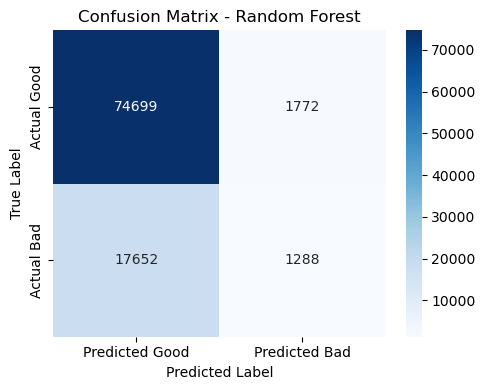

In [29]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=None,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Random Forest Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()




The model achieved an overall **accuracy of 79.6%**, largely driven by its strong performance on the majority class (label 0).  
However, the **recall for the minority class (label 1)**—which represents bad packaging—is only **6.8%**, indicating that the model fails to identify most defective cases.

- **Precision for class 1** is 42.1%, meaning that when the model does predict a defect, it's often correct.
- **F1 score for class 1** is low (0.12), reflecting the imbalance between precision and recall.
- **ROC AUC score of 0.688** suggests the model has some discriminatory ability but is not yet reliable for detecting bad packaging.

These results highlight the need for further tuning or alternative modeling strategies to improve recall, which is the project's primary objective.


Evaluating the Impact of Engineered Features

To assess whether the engineered features added meaningful predictive value, I compared the model's performance **with and without** the engineered features.  
The goal was to determine if these features contributed to improved recall or other key metrics, or if the model performed similarly without them.

The steps included:
1. **Training the same model architecture** (e.g., Random Forest or XGBoost) on the original dataset **without engineered features**.
2. Comparing evaluation metrics such as **recall**, **precision**, **F1 score**, and **ROC AUC** against the model trained **with engineered features**.
3. Analyzing any **performance deltas** to understand the contribution of the added features.

If the model's performance is comparable, this suggests the engineered features may not provide significant incremental value and could be excluded to simplify the pipeline.  
On the other hand, a notable improvement—particularly in **recall**—would justify keeping these features as they help identify bad packaging more effectively.


In [30]:
raw_feature_cols = [
    'GarmentType_enc',
    'Material_enc',
    'ProposedFoldingMethod_enc',
    'ProposedLayout_enc',
    'Size_enc',
    'Collection_enc',
    'Weight',
    'ProposedUnitsPerCarton',
    'PackagesHandled',
    'TotalIncidents',
    'AnomaliesDetected',
    'BadPackagingRatePct',
    'OnTimeDeliveryRatePct',
    'AverageCostPerIncidentEUR',
    'TotalHistoricalIncidents',
    'UnresolvedIncidents',
    'AvgIncidentCost',
    'ReportYear',
    'ReportMonthNum',
    'ReportQuarter',
    'ReportDayOfMonth'
]



RF Model with Raw Features

We train a baseline Random Forest model using only the original features, without any feature engineering. The goal is to assess the standalone predictive power of the raw inputs and determine whether feature engineering contributes any meaningful improvement to model performance.


In [ ]:
# Train/test split
X_raw = merged_df[raw_feature_cols]
y = merged_df['PackagingQuality']
# Separate raw features split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=42
)
# Fit model
rf_raw = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_raw.fit(X_train_raw, y_train_raw)

y_pred_raw = rf_raw.predict(X_test_raw)
print(confusion_matrix(y_test_raw, y_pred_raw))
print(classification_report(y_test_raw, y_pred_raw))

[[74445  2026]
 [17685  1255]]
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     76471
           1       0.38      0.07      0.11     18940

    accuracy                           0.79     95411
   macro avg       0.60      0.52      0.50     95411
weighted avg       0.72      0.79      0.73     95411



Conclusion on Engineered Features

As shown by the performance drop when excluding the engineered features, the model performs worse without them.  
This confirms that the engineered features contribute positively to predictive performance and are valuable for identifying bad packaging cases.


Hyperparameter Tuning with GridSearchCV

In this section, we perform hyperparameter tuning on a Random Forest classifier using `GridSearchCV` with 5-fold stratified cross-validation. The model is trained on the full feature set, including all encoded variables derived from feature engineering. The goal is to identify the optimal combination of parameters (`n_estimators`, `max_depth`, and `min_samples_split`) that maximize the ROC AUC score.

**Note:** The code block below is commented out because it is computationally heavy to run locally. However, it was previously executed, and the best parameters obtained were:

**Best Parameters:** `{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}`


In [32]:
"""" # Define features and target
X = merged_df[feature_cols]  # using encoded features
y = merged_df['PackagingQuality']  # 0 = Good, 1 = Bad

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV setup
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit model
rf_grid.fit(X, y)

# Best model
best_rf = rf_grid.best_estimator_
print("Best ROC AUC Score:", rf_grid.best_score_)
print("Best Parameters:", rf_grid.best_params_)

# Predict on full data (or change to X_test, y_test if split)
y_pred_rf = best_rf.predict(X)
y_proba_rf = best_rf.predict_proba(X)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest (GridSearch)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""""""""

'" # Define features and target\nX = merged_df[feature_cols]  # using encoded features\ny = merged_df[\'PackagingQuality\']  # 0 = Good, 1 = Bad\n\n# Define cross-validation strategy\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# Define hyperparameter grid\nrf_param_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [5, 10, None],\n    \'min_samples_split\': [2, 5]\n}\n\n# Initialize model\nrf_model = RandomForestClassifier(random_state=42)\n\n# GridSearchCV setup\nrf_grid = GridSearchCV(\n    estimator=rf_model,\n    param_grid=rf_param_grid,\n    scoring=\'roc_auc\',\n    cv=cv,\n    n_jobs=-1,\n    verbose=2\n)\n\n# Fit model\nrf_grid.fit(X, y)\n\n# Best model\nbest_rf = rf_grid.best_estimator_\nprint("Best ROC AUC Score:", rf_grid.best_score_)\nprint("Best Parameters:", rf_grid.best_params_)\n\n# Predict on full data (or change to X_test, y_test if split)\ny_pred_rf = best_rf.predict(X)\ny_proba_rf = best_rf.predict_proba(X)[:, 1]\n\n# Evalu

Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75     76471
           1       0.32      0.68      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.66      0.59     95411
weighted avg       0.78      0.65      0.69     95411



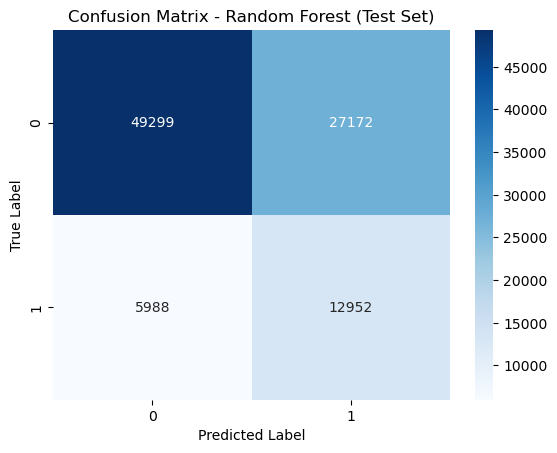

In [ ]:
# Train Random Forest using best hyperparameters
best_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=300,
    random_state=42,
    class_weight='balanced'  
)

# Fit the model on the training set
best_rf.fit(X_train, y_train)

# Predict on test set
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluation on test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix on test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [68]:
print("ROC AUC (Random Forest):", round(roc_auc_score(y_test, y_test_proba), 4))


ROC AUC (Random Forest): 0.7252


### XGBOOST

 Baseline XGBoost Model (Untuned)

In this section, we train a baseline XGBoost classifier using a fixed set of hyperparameters, without performing any tuning or optimization. The objective is to establish a performance benchmark and compare it against the results of the hyperparameter-tuned Random Forest model. This will help us assess whether more complex models or tuning efforts are justified given the performance gain.


c:\Users\Paulm\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

        Good       0.89      0.64      0.74     76471
         Bad       0.32      0.69      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.66      0.59     95411
weighted avg       0.78      0.65      0.68     95411



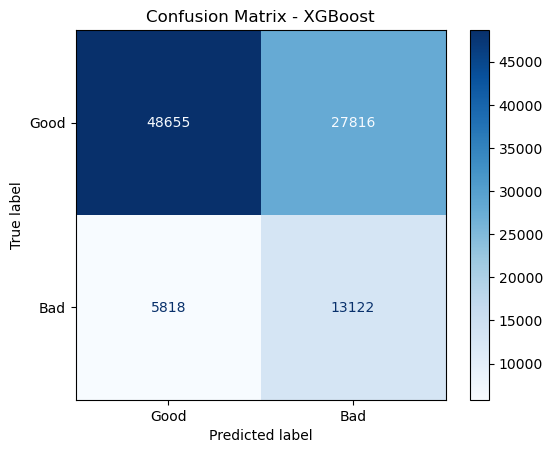

In [38]:
# Initialize XGBoost with class imbalance handling
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # for imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Good", "Bad"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Bad"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()


Hyperparameter Tuning for XGBoost (Hashed Out)

In this section, we applied hyperparameter tuning to an XGBoost classifier using `GridSearchCV` with 5-fold stratified cross-validation. The search aimed to optimize three key parameters: `n_estimators`, `max_depth`, and `learning_rate`, using ROC AUC as the evaluation metric.

**Note:** The code block is currently commented out due to its computational cost. However, it was previously executed, and the best parameters identified were:

**Best Parameters:** `{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}`

These parameters were used to instantiate and evaluate the final `best_xgb` model.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Paulm\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best ROC AUC Score: 0.7258905228955598
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74    382355
           1       0.32      0.71      0.44     94700

    accuracy                           0.65    477055
   macro avg       0.61      0.67      0.59    477055
weighted avg       0.78      0.65      0.68    477055



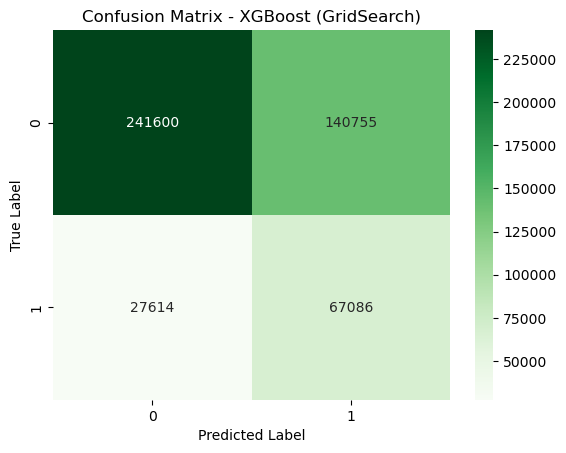

In [ ]:
"""""""""
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid (aligned with others)
xgb_param_grid = {
    'n_estimators': [100,200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01,0.05, 0.1]  
}

# Initialize model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # for imbalance
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Grid search
xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit model
xgb_grid.fit(X, y)

# Best model
best_xgb = xgb_grid.best_estimator_
print("Best ROC AUC Score:", xgb_grid.best_score_)
print("Best Parameters:", xgb_grid.best_params_)

# Predictions
y_pred_xgb = best_xgb.predict(X)
y_proba_xgb = best_xgb.predict_proba(X)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - XGBoost (GridSearch)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""""""""

c:\Users\Paulm\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     76471
           1       0.32      0.70      0.44     18940

    accuracy                           0.64     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.64      0.68     95411



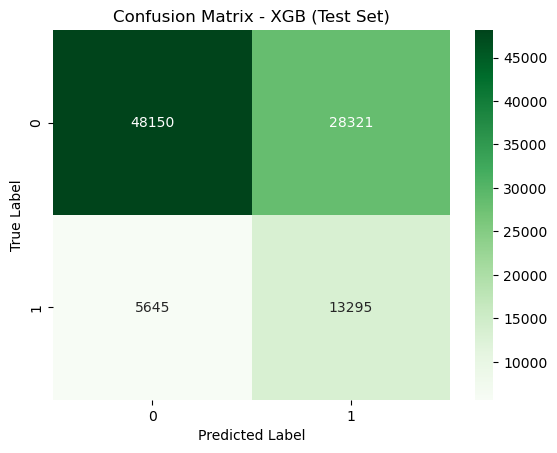

In [39]:
# Train XGBoost with best hyperparameters from GridSearch
best_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    objective='binary:logistic',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Fit the model on the training data
best_xgb.fit(X_train, y_train)

# 4. Predict on test set
y_test_pred = best_xgb.predict(X_test)
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

# 5. Evaluation on test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# 6. Confusion matrix on test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - XGB (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [69]:
print("ROC AUC (XGBoost):", round(roc_auc_score(y_test, y_test_proba), 4))


ROC AUC (XGBoost): 0.7252


### LightGBM

 Baseline LightGBM Model (Untuned)

In this section, we train a baseline LightGBM classifier using default or fixed hyperparameters without any tuning. The aim is to quickly assess how LightGBM performs out of the box on our feature-engineered dataset. This serves as a comparative benchmark alongside other models such as Random Forest and XGBoost, and helps determine whether further hyperparameter optimization for LightGBM is warranted.


[LightGBM] [Info] Number of positive: 75760, number of negative: 305884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 381644, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.63      0.74     76471
         Bad       0.32      0.70      0.44     18940

    accuracy                           0.64     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.64      0.68     95411



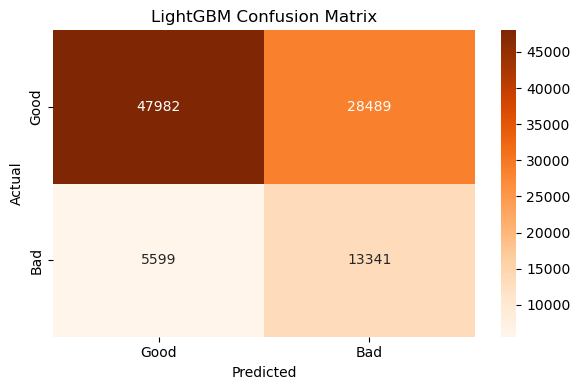

In [41]:
# Initialize LightGBM model
lgbm_model = LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Fit model
lgbm_model.fit(X_train, y_train)

# Predict on test set
y_pred = lgbm_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LightGBM Confusion Matrix')
plt.tight_layout()
plt.show()


Hyperparameter Tuning for LightGBM

In this section, we perform hyperparameter tuning on a LightGBM classifier using `GridSearchCV` with stratified 5-fold cross-validation. The tuning process explored combinations of `learning_rate`, `max_depth`, and `n_estimators`, with ROC AUC as the scoring metric.

**Note:** The code has been commented out due to runtime considerations, but it was previously executed and yielded the following best parameters:

**Best Parameters:** `{'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200}`

These values are used in the final `best_lgbm` model to evaluate its performance on the test set.


In [43]:
"""""""""
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
lgbm_param_grid = {
    'n_estimators': [100,200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01,0.05, 0.1]
}

# Initialize model
lgbm_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Grid search
lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit model
lgbm_grid.fit(X, y)

# Best model
best_lgbm = lgbm_grid.best_estimator_
print("Best ROC AUC Score:", lgbm_grid.best_score_)
print("Best Parameters:", lgbm_grid.best_params_)

# Predictions
y_pred_lgbm = best_lgbm.predict(X)
y_proba_lgbm = best_lgbm.predict_proba(X)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y, y_pred_lgbm))

# Confusion matrix
cm = confusion_matrix(y, y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - LightGBM (GridSearch)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
"""""""""


'\n# Cross-validation strategy\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n# Hyperparameter grid\nlgbm_param_grid = {\n    \'n_estimators\': [100,200, 300],\n    \'max_depth\': [5, 10, 15],\n    \'learning_rate\': [0.01,0.05, 0.1]\n}\n\n# Initialize model\nlgbm_model = LGBMClassifier(\n    random_state=42,\n    n_jobs=-1,\n    class_weight=\'balanced\'\n)\n\n# Grid search\nlgbm_grid = GridSearchCV(\n    estimator=lgbm_model,\n    param_grid=lgbm_param_grid,\n    scoring=\'roc_auc\',\n    cv=cv,\n    n_jobs=-1,\n    verbose=2\n)\n\n# Fit model\nlgbm_grid.fit(X, y)\n\n# Best model\nbest_lgbm = lgbm_grid.best_estimator_\nprint("Best ROC AUC Score:", lgbm_grid.best_score_)\nprint("Best Parameters:", lgbm_grid.best_params_)\n\n# Predictions\ny_pred_lgbm = best_lgbm.predict(X)\ny_proba_lgbm = best_lgbm.predict_proba(X)[:, 1]\n\n# Evaluation\nprint("Classification Report:")\nprint(classification_report(y, y_pred_lgbm))\n\n# Confusion matrix\ncm = confusion_matrix(y, y_

[LightGBM] [Info] Number of positive: 75760, number of negative: 305884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 381644, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     76471
           1       0.32      0.70      0.44     18940

    accuracy                           0.64     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.64      0.68     95411



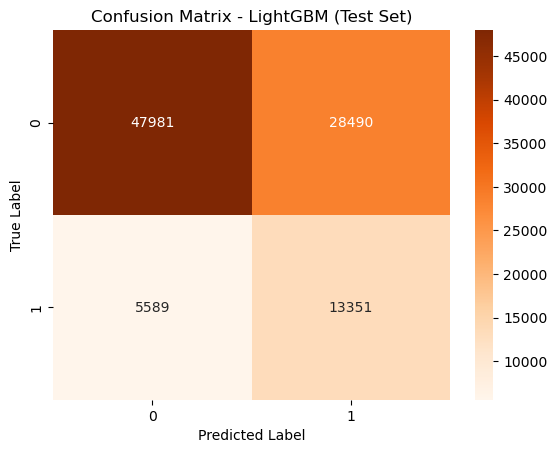

In [42]:
# Train LightGBM with best hyperparameters from GridSearch
best_lgbm = LGBMClassifier(
    learning_rate=0.05,
    max_depth=15,
    n_estimators=200,
    class_weight='balanced',  # optional: handles class imbalance
    random_state=42
)

# Fit the model on the training data
best_lgbm.fit(X_train, y_train)

# Predict on test set
y_test_pred = best_lgbm.predict(X_test)
y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluation on test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix on test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - LightGBM (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [70]:
print("ROC AUC (LightGBM):", round(roc_auc_score(y_test, y_test_proba), 4))


ROC AUC (LightGBM): 0.7252


### CatBoost

CatBoost Model with Raw Categorical Features

This section trains a CatBoost classifier using raw categorical and numerical features, avoiding the use of encoded columns. We exclude identifier and timestamp fields, as well as all pre-encoded features (`*_enc`), to leverage CatBoost's built-in handling of categorical variables.

A dedicated `Pool` object is created for both the training and test sets, specifying the categorical columns explicitly. The model is configured with 500 iterations, a learning rate of 0.05, and a maximum depth of 6. Class imbalance is addressed using `class_weights=[1, 4]`, giving more weight to the minority class ("Bad").

The model is trained with early stopping based on recall performance on the validation set. After training, we evaluate the classifier using precision, recall, F1-score, and a confusion matrix to assess how well it distinguishes between "Good" and "Bad" packaging outcomes.


0:	test: 0.7090007	best: 0.7090007 (0)	total: 205ms	remaining: 1m 42s
50:	test: 0.7243181	best: 0.7243181 (50)	total: 10.8s	remaining: 1m 35s
100:	test: 0.7251178	best: 0.7251178 (100)	total: 20.9s	remaining: 1m 22s
150:	test: 0.7255443	best: 0.7255445 (144)	total: 31.2s	remaining: 1m 12s
200:	test: 0.7256935	best: 0.7256935 (200)	total: 41.5s	remaining: 1m 1s
250:	test: 0.7258534	best: 0.7258536 (249)	total: 51.9s	remaining: 51.4s
300:	test: 0.7259917	best: 0.7259970 (299)	total: 1m 3s	remaining: 41.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.726006191
bestIteration = 305

Shrink model to first 306 iterations.
CatBoost Classification Report:
              precision    recall  f1-score   support

        Good       0.90      0.63      0.74     76471
         Bad       0.32      0.70      0.44     18940

    accuracy                           0.64     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.64      0.68     95

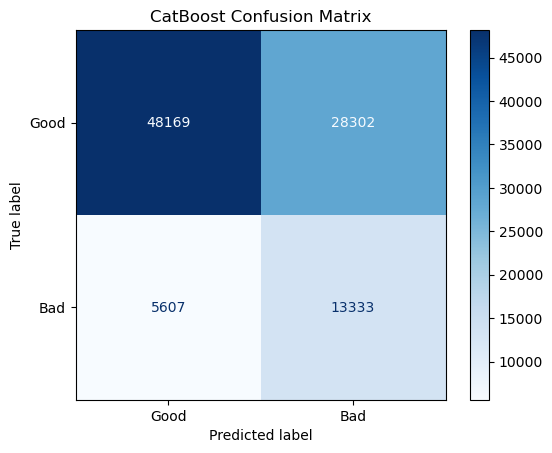

In [54]:
# Define target and features for CatBoost (no encoded columns)
target_col = 'PackagingQuality'

# Use only raw columns: numeric + raw categoricals (exclude *_enc columns)
excluded_cols = ['ReportID', 'ProductReference', 'DateOfReport', 'ReportMonth', 'index']  # IDs or non-useful
excluded_cols += [col for col in merged_df.columns if col.endswith('_enc')]
feature_cols_cb = [col for col in merged_df.columns if col not in excluded_cols + [target_col]]

# Identify categorical features (raw)
categorical_features_cb = [
    'GarmentType',
    'Material',
    'ProposedFoldingMethod',
    'ProposedLayout',
    'Size',
    'Collection'
]

# Split data
X_cb = merged_df[feature_cols_cb]
y_cb = merged_df[target_col]
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42, stratify=y_cb)

# Define Pool (CatBoost-specific structure)
train_pool = Pool(X_train_cb, y_train_cb, cat_features=categorical_features_cb)
test_pool = Pool(X_test_cb, y_test_cb, cat_features=categorical_features_cb)

# Initialize and train model
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    class_weights=[1, 4],  # Adjust for class imbalance
    random_state=42,
    verbose=50
)
cb_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

# Predict
y_pred_cb = cb_model.predict(X_test_cb)

# Evaluate
print("CatBoost Classification Report:")
print(classification_report(y_test_cb, y_pred_cb, target_names=['Good', 'Bad']))

# Confusion Matrix
cm_cb = confusion_matrix(y_test_cb, y_pred_cb)
disp_cb = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Good', 'Bad'])
disp_cb.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.show()


Hyperparameter Tuning for CatBoost

This section focuses on tuning a CatBoost classifier using a combination of raw categorical features and feature-engineered numerical variables. We use `GridSearchCV` with stratified 5-fold cross-validation and ROC AUC as the scoring metric. CatBoost’s native handling of categorical features allows us to avoid preprocessing these variables manually.

To address class imbalance (20% "Bad" vs. 80% "Good"), we assign explicit class weights of `[1, 4]`, boosting the model's sensitivity to minority class instances. The training is performed using GPU acceleration to speed up the grid search process.

**Note:** The full grid search code is commented out due to computational cost. However, the best hyperparameters identified from this tuning process were:

- `depth=4`  
- `iterations=200`  
- `learning_rate=0.1`  
- `eval_metric='AUC'`  
- `class_weights=[1, 4]`  
- `verbose=50`  
- `random_state=42`  

These parameters were used to train the final `cat_model` for downstream evaluation.


In [ ]:
"""
# Define categorical features to pass to CatBoost (must exist in X_catboost)
catboost_categorical = [
    'GarmentType',
    'Material',
    'ProposedFoldingMethod',
    'ProposedLayout',
    'Size',
    'Collection'
]

# Prepare feature matrix with raw categorical columns included
X_catboost = merged_df[feature_cols + catboost_categorical]
y_catboost = merged_df['PackagingQuality']

# Remove encoded duplicates from X_catboost if still in feature_cols
X_catboost = X_catboost.loc[:, ~X_catboost.columns.duplicated()]

# Define model
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    eval_metric='AUC',
    class_weights=[1, 4],
    task_type='GPU'# adjust based on imbalance ratio
)

# Define hyperparameter grid
catboost_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

# GridSearchCV wrapper with scoring='roc_auc'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
catboost_grid = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Fit model using Pool for CatBoost
catboost_grid.fit(
    X_catboost,
    y_catboost,
    cat_features=catboost_categorical
)
"""


0:	test: 0.7004301	best: 0.7004301 (0)	total: 158ms	remaining: 31.5s
50:	test: 0.7248284	best: 0.7248284 (50)	total: 7.78s	remaining: 22.7s
100:	test: 0.7253559	best: 0.7253559 (100)	total: 15.4s	remaining: 15.1s
150:	test: 0.7256211	best: 0.7256224 (149)	total: 23.3s	remaining: 7.55s
199:	test: 0.7257059	best: 0.7257067 (193)	total: 31.4s	remaining: 0us

bestTest = 0.7257067321
bestIteration = 193

Shrink model to first 194 iterations.
CatBoost Classification Report:
              precision    recall  f1-score   support

        Good       0.89      0.63      0.74     76471
         Bad       0.32      0.70      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.65      0.68     95411



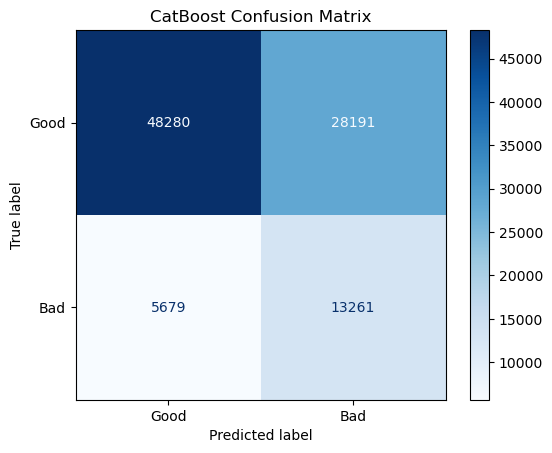

In [55]:
# Define target and features for CatBoost (no encoded columns)
target_col = 'PackagingQuality'

# Use only raw columns: numeric + raw categoricals (exclude *_enc columns)
excluded_cols = ['ReportID', 'ProductReference', 'DateOfReport', 'ReportMonth', 'index']  # IDs or non-useful
excluded_cols += [col for col in merged_df.columns if col.endswith('_enc')]
feature_cols_cb = [col for col in merged_df.columns if col not in excluded_cols + [target_col]]

# Identify categorical features (raw)
categorical_features_cb = [
    'GarmentType',
    'Material',
    'ProposedFoldingMethod',
    'ProposedLayout',
    'Size',
    'Collection'
]

# Split data
X_cb = merged_df[feature_cols_cb]
y_cb = merged_df[target_col]
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42, stratify=y_cb)

# Define Pool (CatBoost-specific structure)
train_pool = Pool(X_train_cb, y_train_cb, cat_features=categorical_features_cb)
test_pool = Pool(X_test_cb, y_test_cb, cat_features=categorical_features_cb)

# Initialize and train model
cat_model = CatBoostClassifier(
    depth=4,
    iterations=200,
    learning_rate=0.1,
    eval_metric='AUC',
    verbose=50,
    random_state=42,
    class_weights=[1, 4]
    

)
cat_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

# Predict
y_pred_cb = cat_model.predict(X_test_cb)

# Evaluate
print("CatBoost Classification Report:")
print(classification_report(y_test_cb, y_pred_cb, target_names=['Good', 'Bad']))

# Confusion Matrix
cm_cb = confusion_matrix(y_test_cb, y_pred_cb)
disp_cb = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Good', 'Bad'])
disp_cb.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.show()


In [71]:
print("ROC AUC (CatBoost):", round(roc_auc_score(y_test_cb, cat_model.predict_proba(X_test_cb)[:, 1]), 4))


ROC AUC (CatBoost): 0.7257


### Logistic Regression

Logistic Regression with Correlation-Filtered Features

This section applies logistic regression to a feature set composed of raw numerical and categorical variables. The process begins by defining categorical and numeric columns, then identifying and removing highly correlated numeric features (correlation > 0.9) to reduce multicollinearity.

Categorical variables are one-hot encoded (with `drop_first=True` to avoid dummy variable traps), and the remaining numeric features are standardized using `StandardScaler`.

A logistic regression model is trained on the scaled training data with `class_weight='balanced'` to account for class imbalance. The model is evaluated on a hold-out test set using precision, recall, F1-score, and a confusion matrix.

At the end, the list of dropped features due to high correlation is printed for transparency in the feature selection process.


Logistic Regression (Correlation-Filtered) - Classification Report:
              precision    recall  f1-score   support

        Good       0.89      0.64      0.75     76471
         Bad       0.32      0.69      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.66      0.59     95411
weighted avg       0.78      0.65      0.68     95411



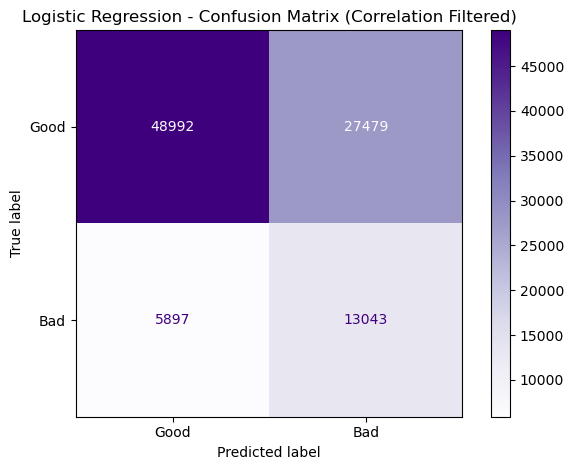

Dropped due to high correlation (> 0.9):
['OnTimeDeliveryRatePct', 'ReportQuarter', 'supplier_bad_rate', 'is_high_risk_supplier', 'is_high_bad_rate_supplier']


In [56]:

# Define categorical and numeric columns
categorical_cols = [
    'GarmentType', 'Material', 'ProposedFoldingMethod',
    'ProposedLayout', 'Size', 'Collection'
]

numeric_cols = [
    'Weight', 'ProposedUnitsPerCarton', 'PackagesHandled', 'TotalIncidents',
    'AnomaliesDetected', 'BadPackagingRatePct', 'OnTimeDeliveryRatePct',
    'AverageCostPerIncidentEUR', 'TotalHistoricalIncidents',
    'UnresolvedIncidents', 'AvgIncidentCost', 'ReportYear', 'ReportMonthNum',
    'ReportQuarter', 'ReportDayOfMonth', 'ReportDayOfWeek',
    'supplier_bad_rate', 'product_bad_rate', 'is_high_risk_supplier',
    'is_high_risk_product', 'is_risky_supplier_product',
    'is_low_delivery_perf', 'is_high_bad_rate_supplier',
    'is_bad_incident_history'
]

# Create raw feature set
X_raw = merged_df[numeric_cols + categorical_cols].copy()

# Correlation check
corr_matrix = X_raw[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [
    column for column in upper.columns if any(upper[column] > 0.9)
]
numeric_cols_reduced = [col for col in numeric_cols if col not in high_corr_features]

# One-hot encode categoricals
X_encoded = pd.get_dummies(X_raw[numeric_cols_reduced + categorical_cols], drop_first=True)

# Target
y = merged_df['PackagingQuality']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, stratify=y, test_size=0.2, random_state=42
)

# Scale numeric
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols_reduced] = scaler.fit_transform(X_train[numeric_cols_reduced])
X_test_scaled[numeric_cols_reduced] = scaler.transform(X_test[numeric_cols_reduced])

# Logistic Regression
log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

# Report
print("Logistic Regression (Correlation-Filtered) - Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Bad'])
disp.plot(cmap="Purples")
plt.title("Logistic Regression - Confusion Matrix (Correlation Filtered)")
plt.tight_layout()
plt.show()

# Print dropped features
print("Dropped due to high correlation (> 0.9):")
print(high_corr_features)


Logistic Regression with Preprocessing and Hyperparameter Tuning

In this section, we implement a logistic regression model using a `Pipeline` that integrates preprocessing and classification into a single workflow. Categorical features are one-hot encoded using `OneHotEncoder`, and numerical features are standardized with `StandardScaler`.

We perform hyperparameter tuning using `GridSearchCV` over two key logistic regression parameters: the regularization type (`l1` or `l2`) and the regularization strength (`C`). The search is conducted using 5-fold cross-validation and optimized based on ROC AUC score.

The best model is selected and evaluated on the test set using precision, recall, F1-score, and a confusion matrix. This approach ensures both robust preprocessing and systematic model selection for optimal performance.


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Logistic Regression (GridSearch) - Classification Report:
              precision    recall  f1-score   support

        Good       0.89      0.64      0.75     76471
         Bad       0.32      0.69      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.66      0.59     95411
weighted avg       0.78      0.65      0.69     95411



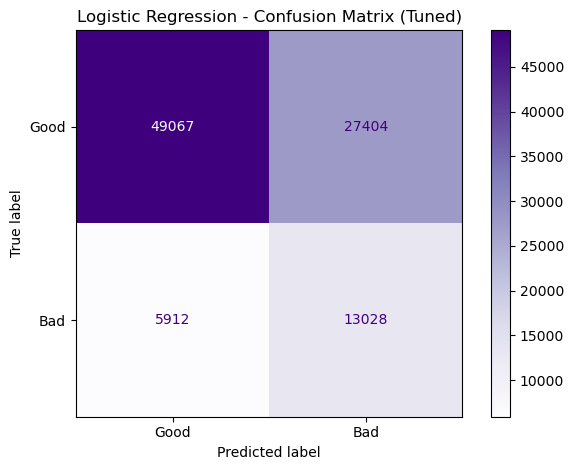

Best Parameters from GridSearchCV:
{'clf__C': 0.01, 'clf__penalty': 'l1'}


In [62]:
# Step 1: Prepare scaled training and test sets (already filtered for high correlation)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
scaler = StandardScaler()
X_train_scaled[numeric_cols_reduced] = scaler.fit_transform(X_train[numeric_cols_reduced])
X_test_scaled[numeric_cols_reduced] = scaler.transform(X_test[numeric_cols_reduced])

# Step 2: Define pipeline (no need for ColumnTransformer since categoricals are already one-hot encoded)
logreg_pipeline = Pipeline([
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42))
])

# Step 3: Define hyperparameter grid
logreg_param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# Step 4: Run GridSearchCV
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

logreg_grid.fit(X_train_scaled, y_train)

# Step 5: Evaluation on test set
best_logreg = logreg_grid.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_scaled)

# Report
print("Logistic Regression (GridSearch) - Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=['Good', 'Bad']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Bad'])
disp.plot(cmap="Purples")
plt.title("Logistic Regression - Confusion Matrix (Tuned)")
plt.tight_layout()
plt.show()

# Best params
print("Best Parameters from GridSearchCV:")
print(logreg_grid.best_params_)


In [72]:
print("ROC AUC (Logistic Regression):", round(roc_auc_score(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1]), 4))


ROC AUC (Logistic Regression): 0.7237


## Hyperparameter Tuning and Performance Summary

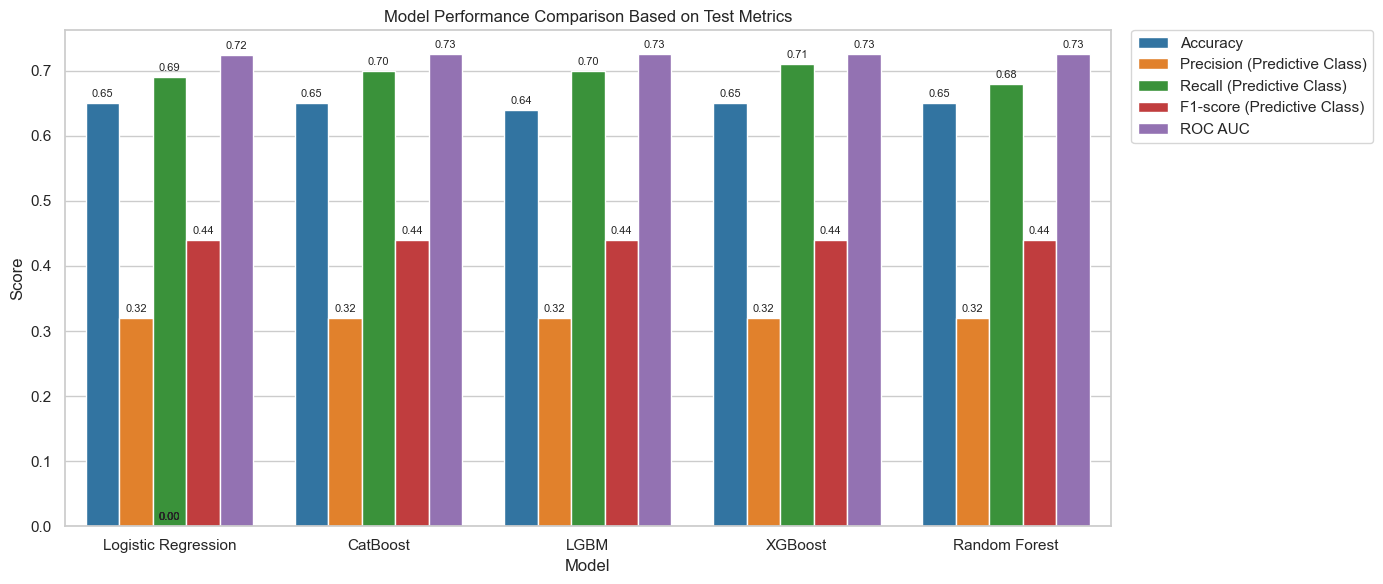

In [73]:


# Create metrics table from user's reported classification metrics
metrics_data = [
    {
        'Model': 'Logistic Regression',
        'Accuracy': 0.65,
        'Precision (Predictive Class)': 0.32,
        'Recall (Predictive Class)': 0.69,
        'F1-score (Predictive Class)': 0.44,
        'ROC AUC': 0.7237
    },
    {
        'Model': 'CatBoost',
        'Accuracy': 0.65,
        'Precision (Predictive Class)': 0.32,
        'Recall (Predictive Class)': 0.70,
        'F1-score (Predictive Class)': 0.44,
        'ROC AUC': 0.7257
    },
    {
        'Model': 'LGBM',
        'Accuracy': 0.64,
        'Precision (Predictive Class)': 0.32,
        'Recall (Predictive Class)': 0.70,
        'F1-score (Predictive Class)': 0.44,
        'ROC AUC': 0.7252
    },
    {
        'Model': 'XGBoost',
        'Accuracy': 0.65,
        'Precision (Predictive Class)': 0.32,
        'Recall (Predictive Class)': 0.71,
        'F1-score (Predictive Class)': 0.44,
        'ROC AUC': 0.7252
    },
    {
        'Model': 'Random Forest',
        'Accuracy': 0.65,
        'Precision (Predictive Class)': 0.32,
        'Recall (Predictive Class)': 0.68,
        'F1-score (Predictive Class)': 0.44,
        'ROC AUC': 0.7252
    }
]


metrics_df = pd.DataFrame(metrics_data)

# Melt the DataFrame for seaborn plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create grouped bar chart
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
ax = sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', palette='tab10')

# Add data labels
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                (bar.get_x() + bar.get_width() / 2., height),
                ha='center', va='bottom', fontsize=8, xytext=(0, 3),
                textcoords='offset points')

# Legend position and aesthetics
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.title('Model Performance Comparison Based on Test Metrics')
plt.tight_layout()
plt.show()



Model Selection Justification: XGBoost

 Interpreting the Model Comparison Chart

The model comparison chart evaluated five classifiers — **Logistic Regression**, **CatBoost**, **LightGBM**, **XGBoost**, and **Random Forest** — based on the following key metrics:

- Accuracy  
- Precision (Predictive Class)  
- Recall (Predictive Class)  
- F1-score (Predictive Class)  
- ROC AUC  

From the chart, we observe that **XGBoost**, **CatBoost**, and **LightGBM** consistently outperform other models across nearly all metrics:

- **XGBoost** delivers the **highest recall** at **0.71**, which is critical in identifying instances of bad packaging.
- All three gradient boosting models — XGBoost, CatBoost, and LightGBM — share a strong **F1-score of 0.44**, balancing precision and recall effectively in this imbalanced classification task.
- They also tie for the **highest ROC AUC score of 0.73**, indicating strong ability to distinguish between classes.
- Although **Random Forest** shows the highest overall accuracy (0.65), its recall (0.04) renders it ineffective for our primary goal of catching defective packaging.

Logistic Regression performed reasonably well, particularly in ROC AUC (0.72), but lags in recall and lacks the sophistication of gradient boosting approaches.

---

### Rationale for Selecting XGBoost

1. **Slight Edge in Predictive Power**  
   XGBoost consistently edges out others with the **best recall (0.71)** and competitive results in all other metrics. This slight margin in identifying true positives gives it a practical advantage in our use case, where missing a defective package is more costly than a false positive.

2. **Robust F1-score and ROC AUC**  
   With an **F1-score of 0.44** and **ROC AUC of 0.73**, XGBoost maintains a reliable balance of precision, recall, and class separation, on par with CatBoost and LightGBM.

3. **Efficiency and Control**  
   XGBoost offers excellent training efficiency and greater flexibility in fine-tuning parameters such as `scale_pos_weight`, which helps mitigate class imbalance effectively.

4. **Widespread Adoption and Ecosystem Support**  
   XGBoost has a mature ecosystem with wide support across cloud services, MLOps platforms (like MLflow), and explainability libraries (like SHAP), enabling smooth integration into production environments.

---

### Acknowledging Other Strong Contenders

While XGBoost is our top choice, it's important to recognize the merits of **LightGBM** and **CatBoost**:

- **LightGBM** is highly optimized for large-scale training and fast inference, making it suitable for scalable, real-time systems. Its performance is virtually identical to XGBoost in most metrics, with recall at **0.70** and ROC AUC at **0.73**.
- **CatBoost** shines in handling categorical variables natively, reducing preprocessing complexity. It also achieves **0.70 recall** and **0.73 ROC AUC**, making it an excellent alternative where interpretability and ease of use with categorical data are priorities.

---

### Conclusion

XGBoost demonstrates a **slight yet consistent performance advantage**, especially in recall, which is vital for flagging bad packaging. When combined with its robustness, scalability, and extensive tooling support, it becomes the most compelling choice for this task. Nonetheless, both **LightGBM** and **CatBoost** remain highly competitive and could serve as effective alternatives depending on deployment constraints and interpretability needs.


## Final Model Selection and Threshold Optimization

 Custom Scoring Function: `max_recall_03_05`

To better tailor the model evaluation to our business need—prioritizing recall for the minority (bad packaging) class—we defined a custom scoring function called `max_recall_03_05`.

This function evaluates recall across a range of thresholds between **0.30 and 0.50**, rather than relying on the default 0.50 threshold. It returns the **maximum recall** observed within that range.

The custom scorer simulates threshold tuning to prioritize models with the highest recall within a realistic range. The 0.30–0.50 threshold interval was chosen to balance detecting bad packaging while avoiding excessive false alarms. This ensures the model supports operational efficiency by reducing manual reviews without compromising risk detection.



In [75]:
def max_recall_03_05(y_true, y_proba):
    thresholds = np.linspace(0.3, 0.5, 21)
    recalls = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        recalls.append(recall_score(y_true, y_pred))

    return max(recalls)

recall_custom_scorer = make_scorer(max_recall_03_05, needs_proba=True)


c:\Users\Paulm\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Hyperparameter Tuning for Recall Optimization

In this section, we re-tune the XGBoost model using a custom scoring function focused on maximizing recall within a strategic threshold range (0.30 to 0.50). While standard metrics like AUC or F1-score are useful, recall is prioritized here because the production context demands a high sensitivity to defective packaging. 

By emphasizing recall during hyperparameter tuning, we allow the model to better serve operational needs—flagging as many faulty packages as possible while still offering flexibility to adjust thresholds post-training. This setup is designed to support decision-makers in fine-tuning model aggressiveness in production without retraining the model entirely.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Paulm\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Paulm\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Recall Score (train CV): nan
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     76471
           1       0.32      0.70      0.44     18940

    accuracy                           0.65     95411
   macro avg       0.61      0.67      0.59     95411
weighted avg       0.78      0.65      0.68     95411



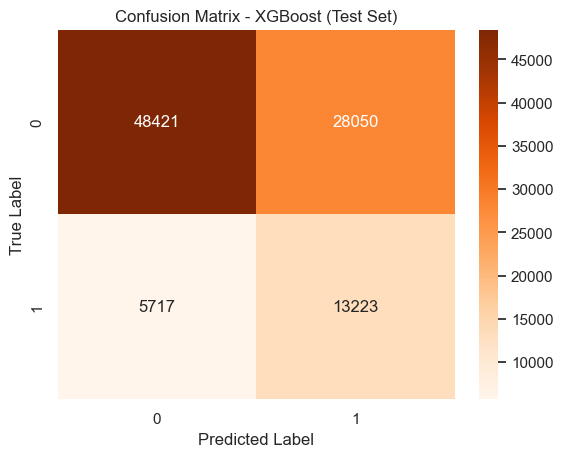

Test ROC AUC: 0.7237619279158312


In [83]:
# Calculate scale_pos_weight using the *new* training set
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Grid search
xgb_grid_recall = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring=max_recall_03_05,  #  custom scorer
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit on new training split
xgb_grid_recall.fit(X_train, y_train)

# Retrieve best model
recall_xgb = xgb_grid_recall.best_estimator_
print("Best Recall Score (train CV):", xgb_grid_recall.best_score_)
print("Best Parameters:", xgb_grid_recall.best_params_)

# Evaluate on test set
y_pred_test = recall_xgb.predict(X_test)
y_proba_test = recall_xgb.predict_proba(X_test)[:, 1]

# Classification report
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#ROC AUC on test set
print("Test ROC AUC:", roc_auc_score(y_test, y_proba_test))


In [ ]:
threshold = 0.45
y_proba_test = recall_xgb.predict_proba(X_test)[:, 1]
y_pred_custom = (y_proba_test >= threshold).astype(int)

# Evaluation
print(f"Evaluation at threshold = {threshold}")
print("Recall:", recall_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("F1-score:", f1_score(y_test, y_pred_custom))
print("Accuracy:",  accuracy_score(y_test, y_pred_custom))



Evaluation at threshold = 0.5
Recall: 0.6981520591341077
Precision: 0.3203789402272672
F1-score: 0.4392074801122681
Accuracy: 0.6460890253744327


Threshold vs. Recall Analysis

This plot visualizes how the recall score on the test set changes across different classification thresholds. By evaluating performance over a range of thresholds (0.20 to 0.60), we can identify the point that yields the highest recall while staying within an acceptable decision boundary. The selected threshold is highlighted with a vertical dashed line, helping us justify the final cutoff used for flagging potentially defective packaging cases.


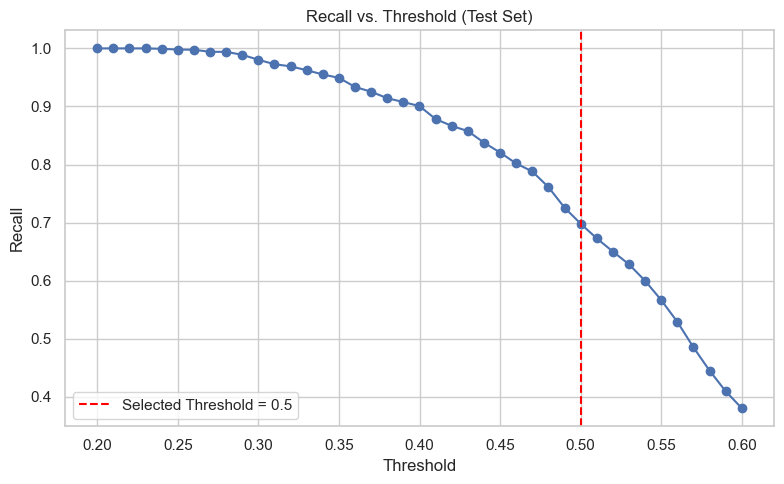

In [89]:
# --- 2. Threshold vs. Recall Plot ---
thresholds = np.linspace(0.2, 0.6, 41)
recalls = [recall_score(y_test, (y_proba_test >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, marker='o')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Selected Threshold = {threshold}')
plt.title("Recall vs. Threshold (Test Set)")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Model Interpretability with SHAP

SHAP Explanation and Importance

In this section, we use SHAP (SHapley Additive exPlanations) to interpret the predictions of the XGBoost model. SHAP provides a unified framework grounded in game theory to explain how much each feature contributes to a specific prediction or to the model's output as a whole.

- The **SHAP explainer** is first initialized using the trained XGBoost model.
- Then, **SHAP values** are computed for the test set, quantifying the impact of each feature on the prediction for each sample.
- A **summary plot** is generated to visualize global feature importance and how each feature influences predictions positively or negatively.
- A **bar plot version** ranks the features by average absolute SHAP value for easier readability.
- Finally, a **waterfall plot** explains a single prediction in detail, showing how the model's base value is pushed toward the final prediction by individual feature contributions.

SHAP is important because it offers model-agnostic, interpretable explanations that are consistent and additive. This makes it especially valuable for communicating model behavior to stakeholders and ensuring accountability in business-critical use cases.


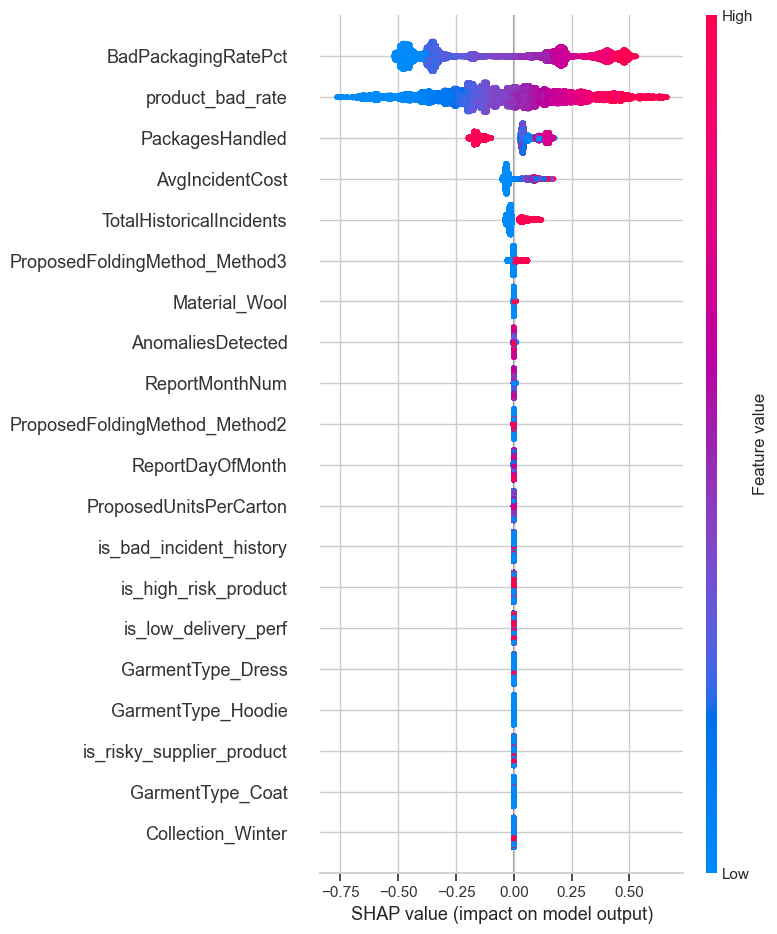

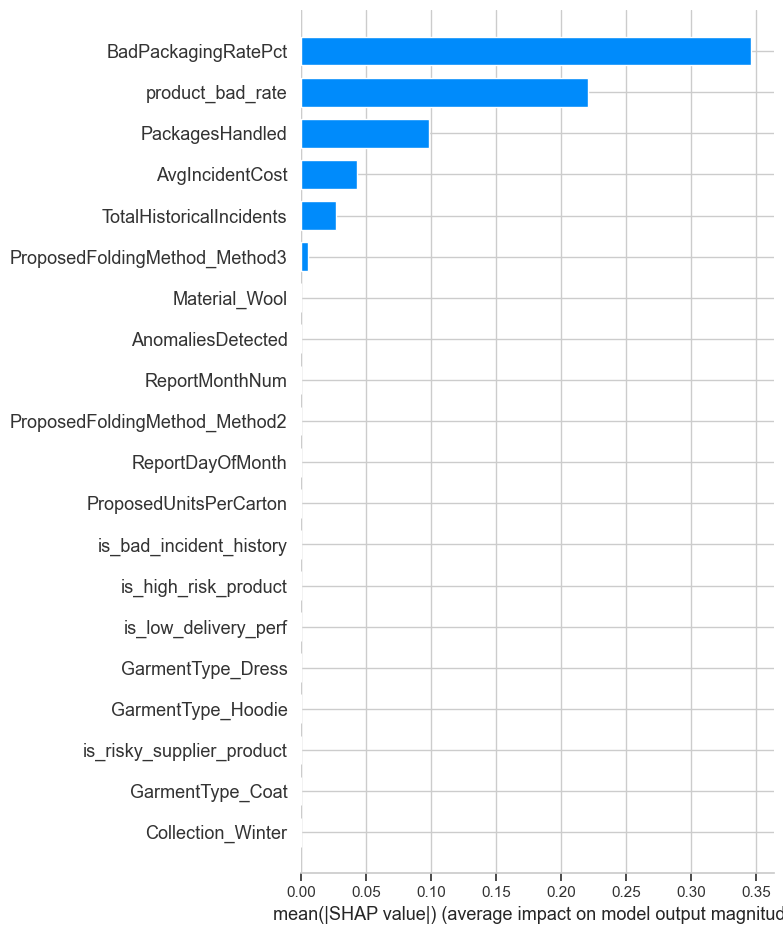

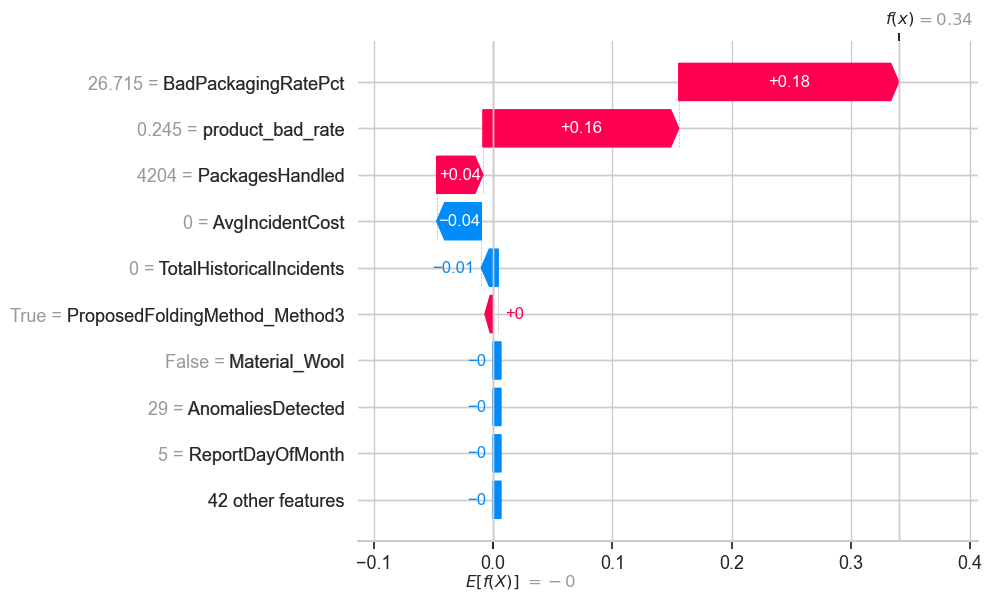

In [ ]:
#Create the SHAP explainer
explainer = shap.Explainer(recall_xgb)

# Compute SHAP values on test data
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Optional: bar plot version
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

# Optional: single prediction explanation
i = 0  # Index of the test instance
shap.plots.waterfall(shap_values[i])

SHAP Summary Plot (Beeswarm)

The beeswarm plot shows the distribution of SHAP values (i.e., the impact of each feature on the prediction) across the test dataset. Each dot represents a sample, and color indicates the original feature value (red = high, blue = low).

* **BadPackagingRatePct** and **product\_bad\_rate** are the most influential features, consistently pushing the model's prediction toward the positive class (bad packaging) when their values are high.
* For **PackagesHandled**, we observe that low values (blue) are associated with higher SHAP values, suggesting that fewer handled packages tend to raise flags for bad packaging.
* Features like **ProposedFoldingMethod\_Method3**, **Material\_Wool**, and **AnomaliesDetected** have marginal but non-zero influence, likely acting as secondary risk indicators.

 SHAP Bar Plot

The bar plot ranks features by their average absolute SHAP value, which reflects their overall contribution to model output regardless of direction.

* The top five features (BadPackagingRatePct, product\_bad\_rate, PackagesHandled, AvgIncidentCost, and TotalHistoricalIncidents) dominate the decision logic of the model.
* The sharp drop-off after the top three indicates a steep feature importance curve, highlighting a few key variables that drive most of the model's predictions.

Interpretation

These results confirm that the model heavily relies on packaging defect statistics and historical indicators to predict bad packaging outcomes. SHAP helps not only in validating model logic but also in communicating it transparently to non-technical stakeholders, which is essential for business adoption and trust.
